# Final Project -  Classification w/ LSTM and Distillation
---
### Chad Weatherly


Data gathered from:
https://health.google.com/covid-19/open-data/raw-data?loc=US_TX

In [30]:
# These modules need to be installed. The requirements.txt file should take care of all that

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader
import session_info
from scipy.stats import sem

print(torch.__version__)

1.10.2


In [2]:
# Info for current Jupyter session modules
session_info.show(html=False)

-----
matplotlib          3.4.3
numpy               1.20.3
pandas              1.3.4
session_info        1.0.0
sklearn             1.0.1
torch               1.10.2
-----
IPython             7.27.0
jupyter_client      7.0.1
jupyter_core        4.8.1
jupyterlab          3.2.1
notebook            6.4.5
-----
Python 3.8.8 (default, Apr 13 2021, 12:59:45) [Clang 10.0.0 ]
macOS-10.16-x86_64-i386-64bit
-----
Session information updated at 2022-05-09 11:55


In [3]:
# Reading in the created data set
# This is all the data gathered for Texas only, for 858 days
data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v3/location/US_TX.csv")
x = data.copy()
# Removing any columns that have only one unique value (like ID, country, etc)
# I found that any column with only 1 or 2 unique values could be removed (unique value and NaN)
for col in x.columns.values:
    if len(x[col].unique()) in [1, 2]:
        x.drop(columns=col, inplace=True)
    # Also removing any columns that are cumulative
    elif col.split('_'):
        if col.split('_')[0] == 'cumulative':
            x.drop(columns=col, inplace=True)
# Fill in NaN values with zero
x.fillna(0, inplace=True)
# Sort by date (This will be important for time series sequencing)
x.sort_values('date', ascending=True)
# Make date the indices and drop date
index = x['date'].values
x.drop(columns='date', inplace=True)
x.head()

,new_confirmed,new_deceased,new_recovered,new_tested,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,...,search_trends_xeroderma,search_trends_xerostomia,search_trends_yawn,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.00,0.35,0.19,9.138889,5.461111,12.977778,0.0,0.0,-0.271605,51.226250
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.93,0.39,0.18,11.822222,6.883333,19.711111,0.0,0.0,5.382716,64.926153
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.85,0.37,0.16,10.222222,5.050000,16.127778,0.0,0.0,1.629630,55.375725
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.17,0.38,0.20,7.422222,-1.738889,20.072222,0.0,0.0,-2.537037,49.250649
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.21,0.38,0.20,10.688889,0.700000,22.100000,0.0,0.0,-3.141975,37.719831


In [4]:
# x.columns.values

In [5]:
# Reading in data and scaling it 
scaler = MinMaxScaler()

cols = x.columns.values
x = pd.DataFrame(scaler.fit_transform(x), columns=cols)
x.index = index

# Setting target values
y_col = 'new_hospitalized_patients'

x.head()
# What the data set looks like

,new_confirmed,new_deceased,new_recovered,new_tested,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,...,search_trends_xeroderma,search_trends_xerostomia,search_trends_yawn,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity
2020-01-01,0.000036,0.0,0.044013,0.174193,0.0,0.0,0.0,0.19165,0.485404,0.051209,...,0.530035,0.583333,0.730769,0.463339,0.498743,0.423924,0.0,0.0,0.409135,0.535013
2020-01-02,0.000036,0.0,0.044013,0.174193,0.0,0.0,0.0,0.19165,0.485404,0.051209,...,0.517668,0.650000,0.692308,0.521983,0.533397,0.557017,0.0,0.0,0.555929,0.678097
2020-01-03,0.000036,0.0,0.044013,0.174193,0.0,0.0,0.0,0.19165,0.485404,0.051209,...,0.503534,0.616667,0.615385,0.487015,0.488726,0.486188,0.0,0.0,0.458494,0.578351
2020-01-04,0.000036,0.0,0.044013,0.174193,0.0,0.0,0.0,0.19165,0.485404,0.051209,...,0.560071,0.633333,0.769231,0.425821,0.323310,0.564155,0.0,0.0,0.350321,0.514380
2020-01-05,0.000036,0.0,0.044013,0.174193,0.0,0.0,0.0,0.19165,0.485404,0.051209,...,0.567138,0.633333,0.769231,0.497214,0.382735,0.604236,0.0,0.0,0.334615,0.393951


In [6]:
# The data needs to be put in sequential length
# The idea is that if given a sequence of 24 consecutive time stamps,
# the model will predict hospitalizations for the next 14 days, given 10 days previous information
seq_len = 24
train_len = 10
# train_len + test_len = seq_len
test_len = 14

# Data set where each observation is 24 consecutive time stamps
temp_x = [x.iloc[i:i+seq_len].values for i in range(len(x)-seq_len)]
temp_y = [x.iloc[i:i+seq_len][y_col].values for i in range(len(x)-seq_len)]

x = torch.tensor([i[0:train_len] for i in temp_x])
y = torch.tensor([i[train_len:seq_len] for i in temp_y])

/var/folders/yf/jvz3gqp91zxdqnsxdmhm157w0000gn/T/ipykernel_2183/1448416109.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640811925055/work/torch/csrc/utils/tensor_new.cpp:201.)
  x = torch.tensor([i[0:train_len] for i in temp_x])


In [7]:
x.shape

torch.Size([837, 10, 472])

In [8]:
y.shape

torch.Size([837, 14])

In [9]:
# Getting data ready, splitting and turning into tensors
rs = 22
kf = KFold(n_splits=5, shuffle=True, random_state=rs)
splits = kf.split(x, y)

k_fold = []
for s in splits:
    
    x_train, x_test, y_train, y_test = x[s[0]], x[s[1]], y[s[0]], y[s[1]]

    x_train.shape

    x_train_tn = []
    for i in range(len(x_train)):
        x_train_tn.append((x_train[i], y_train[i]))
    x_train_tn

    x_test_tn = []
    for i in range(len(x_test)):
        x_test_tn.append((x_test[i], y_test[i]))
    x_test_tn

    # Creating our DataLoaders, which are iterable objects
    batch_size = 10
    x_train = DataLoader(x_train_tn, batch_size=None)
    x_test = DataLoader(x_test_tn, batch_size=None)
    
    k_fold.append({'x_train':x_train, 'x_test':x_test})
    
len(k_fold)

5

In [10]:
k_fold[0]
# Each of the 5 K-folds are PyTorch dataloader objects, iterable objects

{'x_train': <torch.utils.data.dataloader.DataLoader at 0x7f9e044cd970>,
 'x_test': <torch.utils.data.dataloader.DataLoader at 0x7f9e00ace910>}

In [11]:
# Neural Network (nn.Module) is the base class for all neural networks
# Layers themselves are submodules (self.Linear, self.Conv, etc.) that are listed
# as attributes of the NN model

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class lstm(nn.Module):
    def __init__(self, hidden_size):
        # Super inherits all the attributes and methods
        # from the Neural Network __init__ method
        super(lstm, self).__init__()
        # So, now our Neural Network class inherits
        # all of the init attributes/methods from
        # the inherited class, nn.module
        
        # Essentially, our Neural Network class is the same as the nn.module
        # and then we are adding additional functionality to customize
        # it as something that we want
        
        # Submodules like layers or nn.Sequential are listed as attributes of
        # the overall nn.module class (in this case Neural Network)
        
        # Flatten takes each tensor and "flattens" it to create a 1-D vector
        # while ignoring batch, and it is used with nn.Sequential
        # So a tensor of size (32, 1, 25, 25) would be flattened to (32, 625)
        self.flatten = nn.Flatten()
        
        # Doing LSTM layer first
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=x.shape[2], hidden_size=self.hidden_size, batch_first=True,
                           num_layers=3)
        
        # nn.Sequential is a container that holds the layers and chains them together for us
        self.linear_relu_stack = nn.Sequential(
            # Modules held inside are submodules of nn.Sequential
            # nn.Sequential is treated as one submodule of Neural Network
            nn.Linear(150, 25),
            nn.ReLU(),
            nn.Linear(25, 25),
            nn.ReLU(),
            nn.Linear(25, test_len),
            nn.Sigmoid()
        )
    
    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(3,1,self.hidden_size).float(),
                           torch.zeros(3,1,self.hidden_size).float())
        else:
            self.hidden = hidden
        
        out, self.hidden = self.rnn(x, self.hidden)
        out = out.view(len(out), -1)
        logits = self.linear_relu_stack(out)
        
        return logits, self.hidden

# Showing the structure of the Neural Network
temp_model = lstm(hidden_size=25).float().to(device)
print(temp_model)

Using cpu device
lstm(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (rnn): LSTM(472, 25, num_layers=3, batch_first=True)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=14, bias=True)
    (5): Sigmoid()
  )
)


In [12]:
epochs = 100
k_train_teacher_loss = []
k_test_teacher_loss = []
k_teacher_models = []

for k in range(len(k_fold)):
    print(f'K Fold: {k+1}')
    
    model = lstm(hidden_size=15).float().to(device)

    loss_fn = nn.MSELoss()
    # loss_fn = nn.BCELoss(reduction='mean')
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    x_train = k_fold[k]['x_train']
    x_test = k_fold[k]['x_test']
    
    # Training
    model.train()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(epochs+1):
        all_loss = 0
        for i, (x_i, y_i) in enumerate(x_train):
            x_i = x_i.to(device).reshape(1, x_i.shape[0], x_i.shape[1]).type(torch.float)
            y_i = y_i.to(device).type(torch.float).reshape(1, y_i.shape[0])
            y_hat, _ = model(x_i, None)
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y_i).float()
            loss = loss.type(torch.float)
            loss.backward()
            optimizer.step()
            
            # Getting training loss and accuracy
            all_loss += loss.item()
        
        # If you want average loss, uncomment this line below
        # all_loss = all_loss / (len(x_train.dataset))
        
        # Average loss across each epoch
        train_loss.append(all_loss)
        
        if epoch % 20 == 0 or epoch==epochs:
            print(f'\tepoch:{epoch:4}')
            print(f'\t\tTraining loss: {all_loss:10.2f}')
    
    
        # Test Loss
        model.eval()
        with torch.no_grad():
            all_loss = 0
            for i, (x_i, y_i) in enumerate(x_test):
                x_i = x_i.to(device).reshape(1, x_i.shape[0], x_i.shape[1]).type(torch.float)
                y_i = y_i.to(device).type(torch.float).reshape(1, y_i.shape[0])
                y_hat, _ = model(x_i, None)
                loss = loss_fn(y_hat, y_i).float()
                loss = loss.type(torch.float)
                

                # Getting loss and accuracy
                all_loss += loss.item()

            # If you want average loss, uncomment this line below
            # all_loss = all_loss / (len(x_test.dataset))

            # Average loss and accuracy across each epoch
            test_loss.append(all_loss)
            
        if epoch % 20 == 0 or epoch==epochs:
            print(f'\t\tTesting loss: {all_loss:10.2f}')
                
    k_train_teacher_loss.append(train_loss)
    k_test_teacher_loss.append(test_loss)
    k_teacher_models.append(model)

K Fold: 1
	epoch:   0
		Training loss:      73.39
		Testing loss:      13.65
	epoch:  20
		Training loss:      16.11
		Testing loss:      12.60
	epoch:  40
		Training loss:       4.70
		Testing loss:       6.13
	epoch:  60
		Training loss:       2.96
		Testing loss:       5.34
	epoch:  80
		Training loss:       3.19
		Testing loss:       2.70
	epoch: 100
		Training loss:       2.46
		Testing loss:       1.65
K Fold: 2
	epoch:   0
		Training loss:      70.46
		Testing loss:      13.21
	epoch:  20
		Training loss:      14.91
		Testing loss:      11.90
	epoch:  40
		Training loss:       5.46
		Testing loss:       4.25
	epoch:  60
		Training loss:       4.83
		Testing loss:       2.79
	epoch:  80
		Training loss:       3.39
		Testing loss:       1.96
	epoch: 100
		Training loss:       2.10
		Testing loss:       2.61
K Fold: 3
	epoch:   0
		Training loss:      72.85
		Testing loss:      11.77
	epoch:  20
		Training loss:      15.29
		Testing loss:      12.54
	epoch:  40
		Training loss:    

<Figure size 432x288 with 0 Axes>

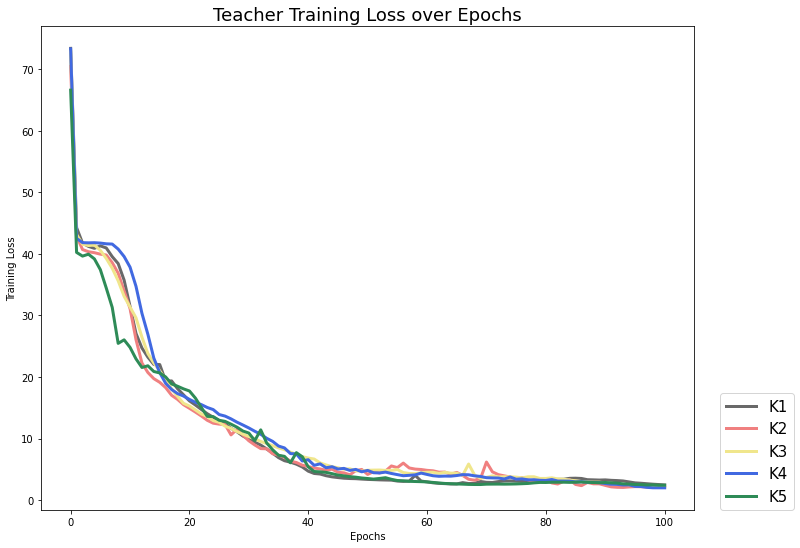

In [13]:
colors = ['dimgray', 'lightcoral', 'khaki', 'royalblue', 'seagreen',
         'sandybrown', 'palegreen', 'darkorchid', 'maroon', 'aqua']

# Showing how the training loss changes over epochs

plt.clf()
plt.figure(figsize=(10, 7.5))
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.tight_layout()
plt.rcParams.update({'font.size': 15})

epochs = np.arange(len(k_train_teacher_loss[0]))
for k in range(len(k_train_teacher_loss)):
    
    plt.plot(epochs, k_train_teacher_loss[k], color=colors[k], label='K' + str(k+1), lw=3)
    
plt.title('Teacher Training Loss over Epochs')
plt.legend(loc=(1.04,0))

plt.savefig('charts/teacher_training_loss.png', bbox_inches='tight')

plt.show()

<Figure size 432x288 with 0 Axes>

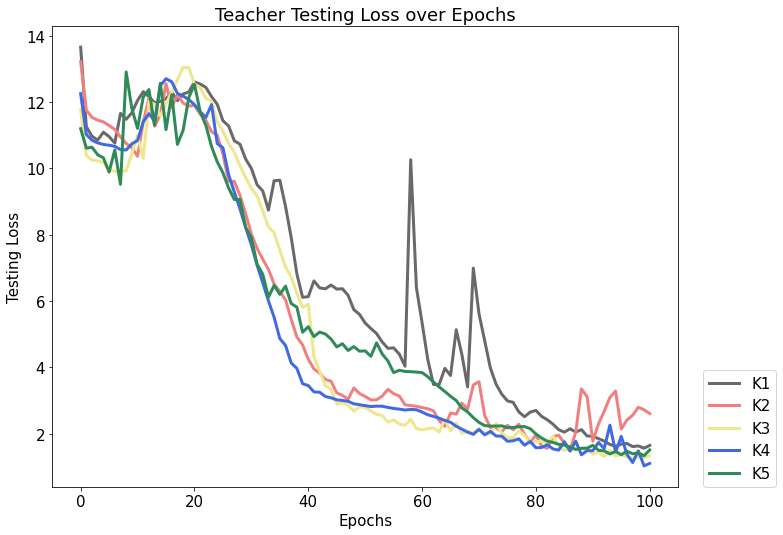

In [14]:
colors = ['dimgray', 'lightcoral', 'khaki', 'royalblue', 'seagreen',
         'sandybrown', 'palegreen', 'darkorchid', 'maroon', 'aqua']

# Showing how the Testing loss changes over epochs

plt.clf()
plt.figure(figsize=(10, 7.5))
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')

plt.tight_layout()
plt.rcParams.update({'font.size': 15})

epochs = np.arange(len(k_test_teacher_loss[0]))
for k in range(len(k_test_teacher_loss)):
    
    plt.plot(epochs, k_test_teacher_loss[k], color=colors[k], label='K' + str(k+1), lw=3)
    
plt.title('Teacher Testing Loss over Epochs')
plt.legend(loc=(1.04,0))

plt.savefig('charts/teacher_testing_loss.png', bbox_inches='tight')

plt.show()

In [36]:
sem(all_train_loss)

0.09211948762341221

In [40]:
train_loss = 0
test_loss = 0
all_train_loss = []
all_test_loss = []

best_loss = 10000

for k in range(len(k_test_teacher_loss)):
    print(f'K-Fold {k+1}')
    # Final Training Loss
    final_train_loss = round(k_train_teacher_loss[k][-1], 2)
    all_train_loss.append(final_train_loss)
    print(f'\tTraining Loss: {final_train_loss}')
    train_loss += final_train_loss
    # Final Testing Loss
    final_test_loss = round(k_test_teacher_loss[k][-1], 2)
    all_test_loss.append(final_test_loss)
    print(f'\t Testing Loss: {final_test_loss}')
    test_loss += final_test_loss
    
    avg_loss = (final_train_loss + final_test_loss) / 2 
    if avg_loss < best_loss:
        best_k = k
        best_loss = avg_loss
        
    # Choosing the teacher model to be the best performing model overall
    teacher_model = k_teacher_models[best_k]
    
print()
print('----------------------------------')
print(f'Average Training Loss: {round(train_loss / len(k_train_teacher_loss), 2)}')
print(f' Average Testing Loss: {round(test_loss / len(k_train_teacher_loss), 2)}')
print()
print(f'Standard Error of Mean Training Loss: {sem(all_train_loss)}')
print(f'Standard Error of Mean Testing Loss: {sem(all_test_loss)}')
print()
print(f'Best Model used for Teacher Model: {best_k+1}')

K-Fold 1
	Training Loss: 2.46
	 Testing Loss: 1.65
K-Fold 2
	Training Loss: 2.1
	 Testing Loss: 2.61
K-Fold 3
	Training Loss: 2.15
	 Testing Loss: 1.34
K-Fold 4
	Training Loss: 1.99
	 Testing Loss: 1.11
K-Fold 5
	Training Loss: 2.42
	 Testing Loss: 1.51

----------------------------------
Average Training Loss: 2.22
 Average Testing Loss: 1.64

Standard Error of Mean Training Loss: 0.09211948762341221
Standard Error of Mean Testing Loss: 0.25775181861628055

Best Model used for Teacher Model: 4


287


<Figure size 432x288 with 0 Axes>

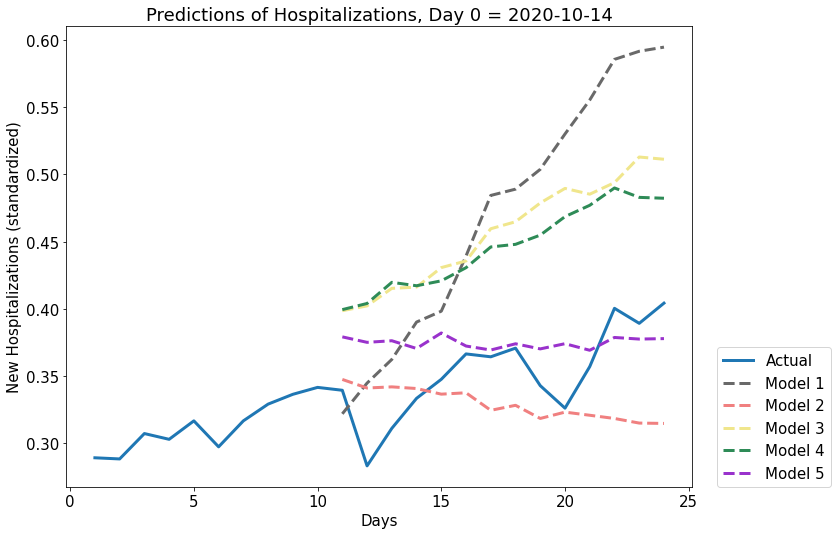

In [27]:
colors = ['dimgray', 'lightcoral', 'khaki', 'seagreen', 'darkorchid',
         'sandybrown', 'palegreen', 'darkorchid', 'maroon', 'royalblue']

# Showing how the different models predict on a random test point

# Getting random test point
i_rand = torch.randint(high=x.shape[0], size=(1, 1)).item()
print(i_rand)
x_i = x[i_rand]
y_i = y[i_rand]

# Getting previous values of hospitalization
prev_vals = []
for i in x_i:
    prev_vals.append(i[4])
y_i = torch.cat((torch.as_tensor(prev_vals), y_i))

x_i = x_i.to(device).reshape(1, x_i.shape[0], x_i.shape[1]).type(torch.float)
y_i = y_i.to(device)

plt.clf()
plt.figure(figsize=(10, 7.5))
plt.xlabel('Days')
plt.ylabel('New Hospitalizations (standardized)')

plt.tight_layout()
plt.rcParams.update({'font.size': 15})

plt.plot(np.arange(1, len(y_i)+1), y_i, label='Actual', lw=3)

with torch.no_grad():
    for k in range(len(k_teacher_models)):
        model = k_teacher_models[k]
        model.eval()
        
        y_hat, _ = model(x_i, None)
        y_hat.reshape(14)
        
        plt.plot(np.arange(train_len+1, len(y_i)+1), np.array(y_hat)[0], '--',
                 color=colors[k], label='Model ' + str(k+1), lw=3)
    
plt.title(f'Predictions of Hospitalizations, Day 0 = {index[i_rand]}')
plt.legend(loc=(1.04,0))
plt.show()

In [17]:
# Neural Network (nn.Module) is the base class for all neural networks
# Layers themselves are submodules (self.Linear, self.Conv, etc.) that are listed
# as attributes of the NN model

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class student(nn.Module):
    def __init__(self):

        super(student, self).__init__()
        
        self.flatten = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10*472, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, test_len),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        flat = self.flatten(x)
        pred = self.linear_relu_stack(flat)
        
        return pred

# Showing the structure of the Neural Network
temp_model = student().float().to(device)
print(temp_model)

Using cpu device
student(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4720, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=14, bias=True)
    (5): Sigmoid()
  )
)


In [18]:
epochs = 100
k_train_student_loss = []
k_test_student_loss = []
k_student_models = []

for k in range(len(k_fold)):
    print(f'K Fold: {k+1}')
    
    student_model = student().float().to(device)

    loss_fn = nn.MSELoss()
    # loss_fn = nn.BCELoss(reduction='mean')
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.5)
    optimizer = torch.optim.Adam(student_model.parameters(), lr=0.00001)
    
    x_train = k_fold[k]['x_train']
    x_test = k_fold[k]['x_test']
    
    # Training
    student_model.train()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(epochs+1):
        all_loss = 0
        for i, (x_i, y_i) in enumerate(x_train):
            x_i = x_i.to(device).reshape(1, x_i.shape[0], x_i.shape[1]).type(torch.float)
            # y_i = y_i.to(device).type(torch.float).reshape(1, y_i.shape[0])
            y_hat = student_model(x_i)
            optimizer.zero_grad()
            
            # Obtaining y_i target values based on teacher
            teacher_model.eval()
            with torch.no_grad():
                y_i, _ = teacher_model(x_i)
            
            loss = loss_fn(y_hat, y_i).float()
            loss = loss.type(torch.float)
            loss.backward()
            optimizer.step()
            
            # Getting training loss and accuracy
            all_loss += loss.item()
        
        # If you want average loss, uncomment this line below
        # all_loss = all_loss / (len(x_train.dataset))
        
        # Average loss across each epoch
        train_loss.append(all_loss)
        
        if epoch % 20 == 0 or epoch==epochs:
            print(f'\tepoch:{epoch:4}')
            print(f'\t\tTraining loss: {all_loss:10.2f}')
    
    
        # Test Loss
        teacher_model.eval()
        student_model.eval()
        with torch.no_grad():
            all_loss = 0
            for i, (x_i, y_i) in enumerate(x_test):
                x_i = x_i.to(device).reshape(1, x_i.shape[0], x_i.shape[1]).type(torch.float)
                # y_i = y_i.to(device).type(torch.float).reshape(1, y_i.shape[0])
                
                # Obtaining y_i target values based on teacher
                with torch.no_grad():
                    y_i, _ = teacher_model(x_i)
                
                y_hat = student_model(x_i)
                loss = loss_fn(y_hat, y_i).float()
                loss = loss.type(torch.float)
                

                # Getting loss and accuracy
                all_loss += loss.item()

            # If you want average loss, uncomment this line below
            # all_loss = all_loss / (len(x_test.dataset))

            # Average loss and accuracy across each epoch
            test_loss.append(all_loss)
            
        if epoch % 20 == 0 or epoch==epochs:
            print(f'\t\tTesting loss: {all_loss:10.2f}')
    
                
    k_train_student_loss.append(train_loss)
    k_test_student_loss.append(test_loss)
    k_student_models.append(student_model)

K Fold: 1
	epoch:   0
		Training loss:      61.36
		Testing loss:      13.72
	epoch:  20
		Training loss:      25.59
		Testing loss:       8.12
	epoch:  40
		Training loss:      13.89
		Testing loss:       6.57
	epoch:  60
		Training loss:       7.08
		Testing loss:       5.62
	epoch:  80
		Training loss:       3.70
		Testing loss:       3.95
	epoch: 100
		Training loss:       2.84
		Testing loss:       2.21
K Fold: 2
	epoch:   0
		Training loss:      68.72
		Testing loss:      14.95
	epoch:  20
		Training loss:      28.63
		Testing loss:       8.34
	epoch:  40
		Training loss:      15.98
		Testing loss:       5.74
	epoch:  60
		Training loss:       9.45
		Testing loss:       3.76
	epoch:  80
		Training loss:       5.22
		Testing loss:       2.87
	epoch: 100
		Training loss:       3.24
		Testing loss:       2.04
K Fold: 3
	epoch:   0
		Training loss:      65.05
		Testing loss:      13.02
	epoch:  20
		Training loss:      25.26
		Testing loss:       8.45
	epoch:  40
		Training loss:    

In [41]:
train_loss = 0
test_loss = 0
all_train_loss = []
all_test_loss = []

best_loss = 10000

for k in range(len(k_test_student_loss)):
    print(f'K-Fold {k+1}')
    # Final Training Loss
    final_train_loss = round(k_train_student_loss[k][-1], 2)
    all_train_loss.append(final_train_loss)
    print(f'\tTraining Loss: {final_train_loss}')
    train_loss += final_train_loss
    # Final Testing Loss
    final_test_loss = round(k_test_student_loss[k][-1], 2)
    all_test_loss.append(final_test_loss)
    print(f'\t Testing Loss: {final_test_loss}')
    test_loss += final_test_loss
    
print()
print('----------------------------------')
print(f'Average Training Loss: {round(train_loss / len(k_train_teacher_loss), 2)}')
print(f' Average Testing Loss: {round(test_loss / len(k_train_teacher_loss), 2)}')
print()
print(f'Standard Error of Mean Training Loss: {sem(all_train_loss)}')
print(f'Standard Error of Mean Testing Loss: {sem(all_test_loss)}')
print()

K-Fold 1
	Training Loss: 2.84
	 Testing Loss: 2.21
K-Fold 2
	Training Loss: 3.24
	 Testing Loss: 2.04
K-Fold 3
	Training Loss: 2.41
	 Testing Loss: 1.75
K-Fold 4
	Training Loss: 2.78
	 Testing Loss: 1.77
K-Fold 5
	Training Loss: 3.0
	 Testing Loss: 1.8

----------------------------------
Average Training Loss: 2.85
 Average Testing Loss: 1.91

Standard Error of Mean Training Loss: 0.136586968631711
Standard Error of Mean Testing Loss: 0.09058697478114609



In [20]:
epochs = 100
k_train_fnn_loss = []
k_test_fnn_loss = []
k_fnn_models = []

for k in range(len(k_fold)):
    print(f'K Fold: {k+1}')
    
    fnn_model = student().float().to(device)

    loss_fn = nn.MSELoss()
    # loss_fn = nn.BCELoss(reduction='mean')
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.5)
    optimizer = torch.optim.Adam(fnn_model.parameters(), lr=0.00001)
    
    x_train = k_fold[k]['x_train']
    x_test = k_fold[k]['x_test']
    
    # Training
    fnn_model.train()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(epochs+1):
        all_loss = 0
        for i, (x_i, y_i) in enumerate(x_train):
            x_i = x_i.to(device).reshape(1, x_i.shape[0], x_i.shape[1]).type(torch.float)
            y_i = y_i.to(device).type(torch.float).reshape(1, y_i.shape[0])
            y_hat = fnn_model(x_i)
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y_i).float()
            loss = loss.type(torch.float)
            loss.backward()
            optimizer.step()
            
            # Getting training loss and accuracy
            all_loss += loss.item()
        
        # If you want average loss, uncomment this line below
        # all_loss = all_loss / (len(x_train.dataset))
        
        # Average loss across each epoch
        train_loss.append(all_loss)
        
        if epoch % 20 == 0 or epoch==epochs:
            print(f'\tepoch:{epoch:4}')
            print(f'\t\tTraining loss: {all_loss:10.2f}')
    
    
        # Test Loss
        fnn_model.eval()
        with torch.no_grad():
            all_loss = 0
            for i, (x_i, y_i) in enumerate(x_test):
                x_i = x_i.to(device).reshape(1, x_i.shape[0], x_i.shape[1]).type(torch.float)
                y_i = y_i.to(device).type(torch.float).reshape(1, y_i.shape[0])
                y_hat = fnn_model(x_i)
                loss = loss_fn(y_hat, y_i).float()
                loss = loss.type(torch.float)
                

                # Getting loss and accuracy
                all_loss += loss.item()

            # If you want average loss, uncomment this line below
            # all_loss = all_loss / (len(x_test.dataset))

            # Average loss and accuracy across each epoch
            test_loss.append(all_loss)
            
        if epoch % 20 == 0 or epoch==epochs:
            print(f'\t\tTesting loss: {all_loss:10.2f}')
    
                
    k_train_fnn_loss.append(train_loss)
    k_test_fnn_loss.append(test_loss)
    k_fnn_models.append(fnn_model)

K Fold: 1
	epoch:   0
		Training loss:      75.56
		Testing loss:      18.42
	epoch:  20
		Training loss:      31.88
		Testing loss:       8.45
	epoch:  40
		Training loss:      16.95
		Testing loss:       5.61
	epoch:  60
		Training loss:       9.97
		Testing loss:       3.59
	epoch:  80
		Training loss:       6.24
		Testing loss:       2.29
	epoch: 100
		Training loss:       4.40
		Testing loss:       1.75
K Fold: 2
	epoch:   0
		Training loss:      69.73
		Testing loss:      14.77
	epoch:  20
		Training loss:      24.64
		Testing loss:       8.67
	epoch:  40
		Training loss:      13.16
		Testing loss:       6.24
	epoch:  60
		Training loss:       7.37
		Testing loss:       4.15
	epoch:  80
		Training loss:       4.59
		Testing loss:       2.66
	epoch: 100
		Training loss:       3.27
		Testing loss:       1.84
K Fold: 3
	epoch:   0
		Training loss:      68.56
		Testing loss:      14.46
	epoch:  20
		Training loss:      25.72
		Testing loss:       8.30
	epoch:  40
		Training loss:    

In [42]:
train_loss = 0
test_loss = 0
all_train_loss = []
all_test_loss = []

best_loss = 10000

for k in range(len(k_test_fnn_loss)):
    print(f'K-Fold {k+1}')
    # Final Training Loss
    final_train_loss = round(k_train_fnn_loss[k][-1], 2)
    all_train_loss.append(final_train_loss)
    print(f'\tTraining Loss: {final_train_loss}')
    train_loss += final_train_loss
    # Final Testing Loss
    final_test_loss = round(k_test_fnn_loss[k][-1], 2)
    all_test_loss.append(final_test_loss)
    print(f'\t Testing Loss: {final_test_loss}')
    test_loss += final_test_loss
    
print()
print('----------------------------------')
print(f'Average Training Loss: {round(train_loss / len(k_train_teacher_loss), 2)}')
print(f' Average Testing Loss: {round(test_loss / len(k_train_teacher_loss), 2)}')
print()
print(f'Standard Error of Mean Training Loss: {sem(all_train_loss)}')
print(f'Standard Error of Mean Testing Loss: {sem(all_test_loss)}')
print()

K-Fold 1
	Training Loss: 4.4
	 Testing Loss: 1.75
K-Fold 2
	Training Loss: 3.27
	 Testing Loss: 1.84
K-Fold 3
	Training Loss: 3.35
	 Testing Loss: 1.4
K-Fold 4
	Training Loss: 3.2
	 Testing Loss: 1.27
K-Fold 5
	Training Loss: 3.69
	 Testing Loss: 2.02

----------------------------------
Average Training Loss: 3.58
 Average Testing Loss: 1.66

Standard Error of Mean Training Loss: 0.22111987698983557
Standard Error of Mean Testing Loss: 0.13959226339593467



In [22]:
num_params = 0
for p in teacher_model.parameters():
    num_params += np.array([i for i in p.shape]).sum()
print(f'Teacher Model Number of Parameters: {num_params}')

num_params = 0
for p in student_model.parameters():
    num_params += np.array([i for i in p.shape]).sum()
print(f'Student Model Number of Parameters: {num_params}')

num_params = 0
for p in fnn_model.parameters():
    num_params += np.array([i for i in p.shape]).sum()
print(f'FNN Model Number of Parameters: {num_params}')

Teacher Model Number of Parameters: 1595
Student Model Number of Parameters: 5048
FNN Model Number of Parameters: 5048


<Figure size 432x288 with 0 Axes>

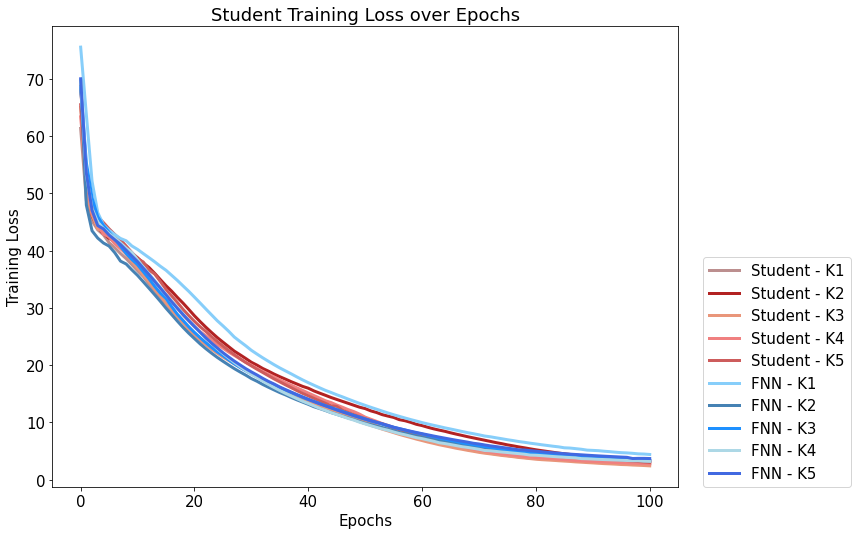

In [23]:
colors1 = ['rosybrown', 'firebrick', 'darksalmon', 'lightcoral', 'indianred']
colors2 = ['lightskyblue', 'steelblue', 'dodgerblue', 'lightblue', 'royalblue']

# Showing how the training loss changes over epochs

plt.clf()
plt.figure(figsize=(10, 7.5))
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.tight_layout()
plt.rcParams.update({'font.size': 15})

epochs = np.arange(len(k_train_student_loss[0]))
for k in range(len(k_train_student_loss)):
    plt.plot(epochs, k_train_student_loss[k], color=colors1[k], label='Student - K' + str(k+1), lw=3)
    
for k in range(len(k_train_fnn_loss)):
    plt.plot(epochs, k_train_fnn_loss[k], color=colors2[k], label='FNN - K' + str(k+1), lw=3)
    
plt.title('Student Training Loss over Epochs')
plt.legend(loc=(1.04,0))

plt.savefig('charts/student_training_loss.png', bbox_inches='tight')

plt.show()

<Figure size 432x288 with 0 Axes>

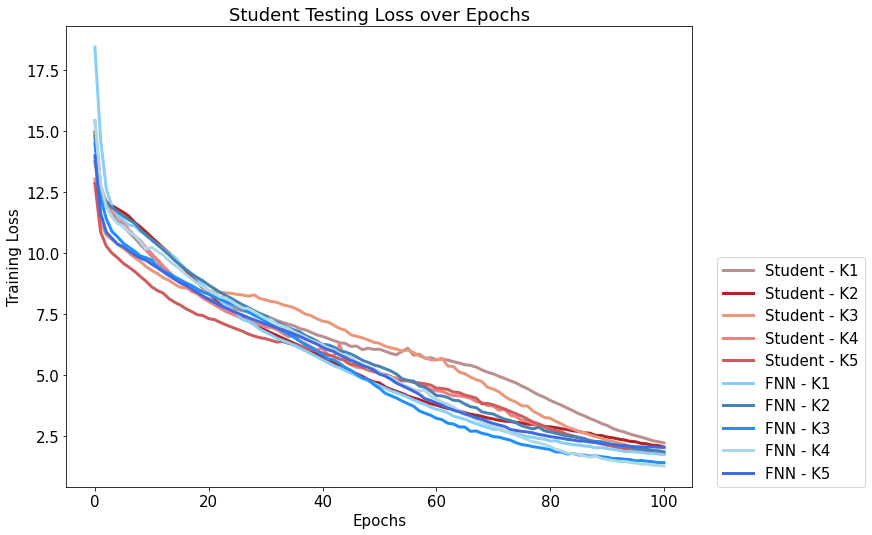

In [24]:
colors1 = ['rosybrown', 'firebrick', 'darksalmon', 'lightcoral', 'indianred']
colors2 = ['lightskyblue', 'steelblue', 'dodgerblue', 'lightblue', 'royalblue']

# Showing how the training loss changes over epochs

plt.clf()
plt.figure(figsize=(10, 7.5))
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.tight_layout()
plt.rcParams.update({'font.size': 15})

epochs = np.arange(len(k_test_student_loss[0]))
for k in range(len(k_test_student_loss)):
    plt.plot(epochs, k_test_student_loss[k], color=colors1[k], label='Student - K' + str(k+1), lw=3)
    
for k in range(len(k_test_fnn_loss)):
    plt.plot(epochs, k_test_fnn_loss[k], color=colors2[k], label='FNN - K' + str(k+1), lw=3)
    
plt.title('Student Testing Loss over Epochs')
plt.legend(loc=(1.04,0))

plt.savefig('charts/student_testing_loss.png', bbox_inches='tight')

plt.show()

411


<Figure size 432x288 with 0 Axes>

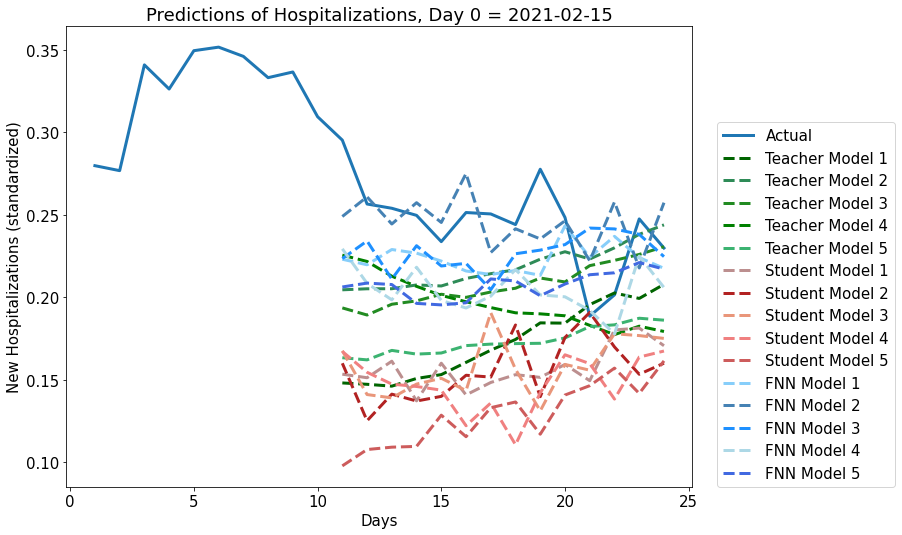

In [49]:
colors1 = ['rosybrown', 'firebrick', 'darksalmon', 'lightcoral', 'indianred']
colors2 = ['lightskyblue', 'steelblue', 'dodgerblue', 'lightblue', 'royalblue']
colors3 = ['darkgreen', 'seagreen', 'forestgreen', 'green', 'mediumseagreen']

# Showing how the different models predict on a random test point

# Getting random test point
i_rand = torch.randint(high=x.shape[0], size=(1, 1)).item()
print(i_rand)
x_i = x[i_rand]
y_i = y[i_rand]

# Getting previous values of hospitalization
prev_vals = []
for i in x_i:
    prev_vals.append(i[4])
y_i = torch.cat((torch.as_tensor(prev_vals), y_i))

x_i = x_i.to(device).reshape(1, x_i.shape[0], x_i.shape[1]).type(torch.float)
y_i = y_i.to(device)

plt.clf()
plt.figure(figsize=(10, 7.5))
plt.xlabel('Days')
plt.ylabel('New Hospitalizations (standardized)')

plt.tight_layout()
plt.rcParams.update({'font.size': 15})

plt.plot(np.arange(1, len(y_i)+1), y_i, label='Actual', lw=3)

# Plotting Teacher Model
with torch.no_grad():
    for k in range(len(k_teacher_models)):
        model = k_teacher_models[k]
        model.eval()
        
        y_hat, _ = model(x_i, None)
        y_hat.reshape(14)
        
        plt.plot(np.arange(train_len+1, len(y_i)+1), np.array(y_hat)[0], '--',
                 color=colors3[k], label='Teacher Model ' + str(k+1), lw=3)
        
# Plotting Student Model
with torch.no_grad():
    for k in range(len(k_student_models)):
        model = k_student_models[k]
        model.eval()
        
        y_hat = model(x_i)
        y_hat.reshape(14)
        
        plt.plot(np.arange(train_len+1, len(y_i)+1), np.array(y_hat)[0], '--',
                 color=colors1[k], label='Student Model ' + str(k+1), lw=3)
        
# Plotting Student FNN Model
with torch.no_grad():
    for k in range(len(k_fnn_models)):
        model = k_fnn_models[k]
        model.eval()
        
        y_hat = model(x_i)
        y_hat.reshape(14)
        
        plt.plot(np.arange(train_len+1, len(y_i)+1), np.array(y_hat)[0], '--',
                 color=colors2[k], label='FNN Model ' + str(k+1), lw=3)
        
        
    
plt.title(f'Predictions of Hospitalizations, Day 0 = {index[i_rand]}')
plt.legend(loc=(1.04,0))
plt.show()

133


<Figure size 432x288 with 0 Axes>

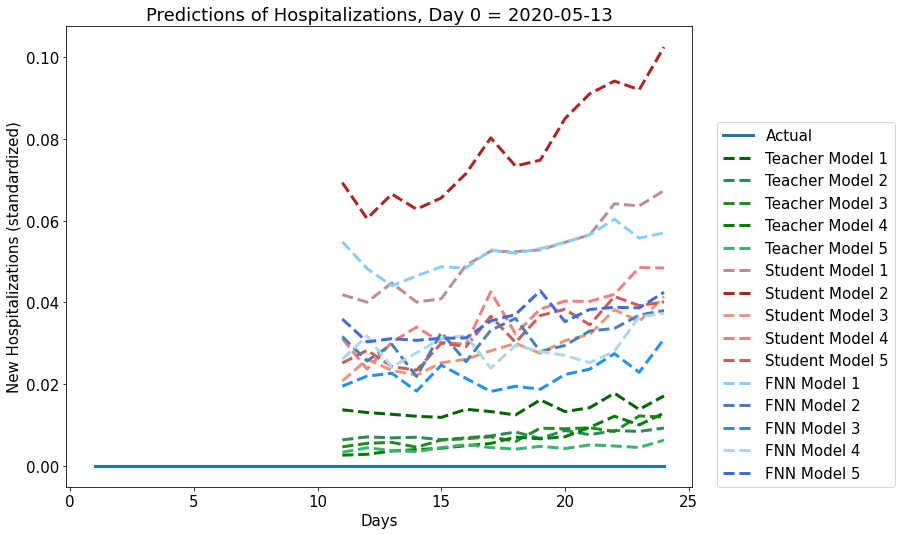

306


<Figure size 432x288 with 0 Axes>

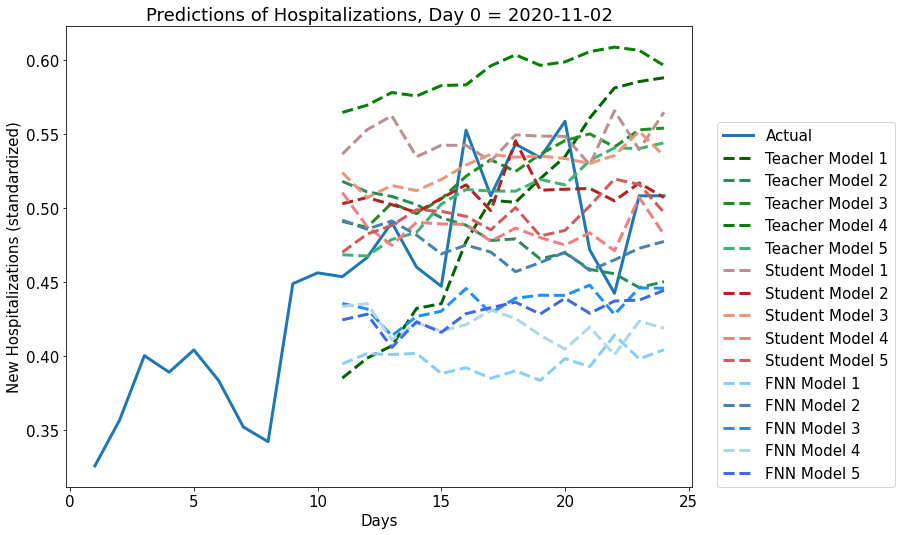

411


<Figure size 432x288 with 0 Axes>

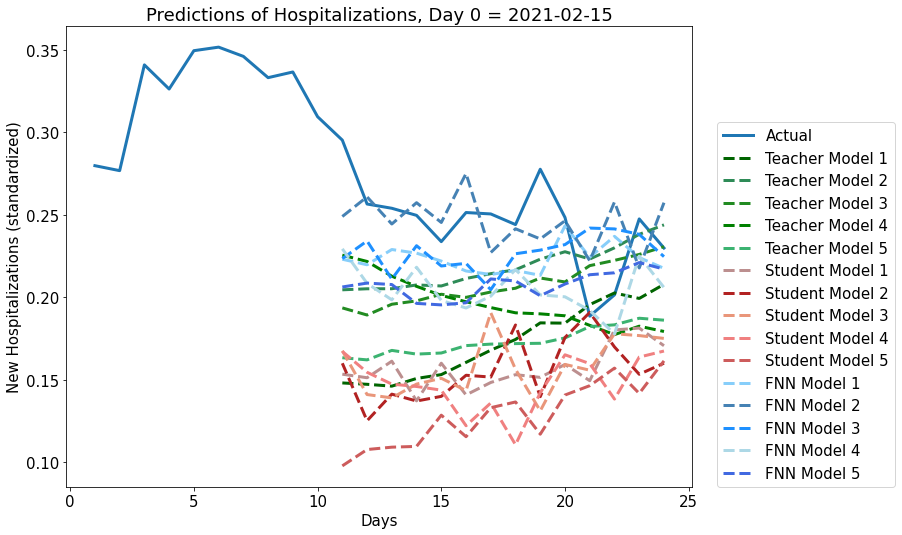

505


<Figure size 432x288 with 0 Axes>

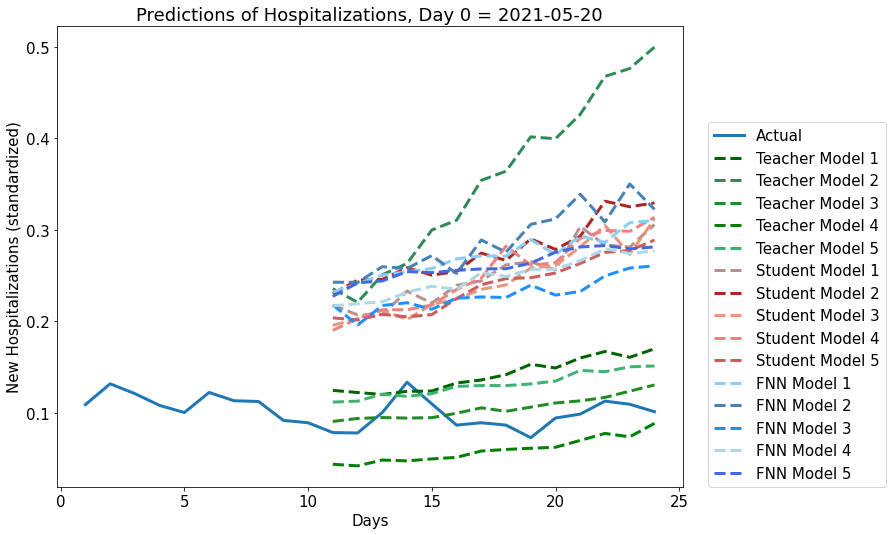

761


<Figure size 432x288 with 0 Axes>

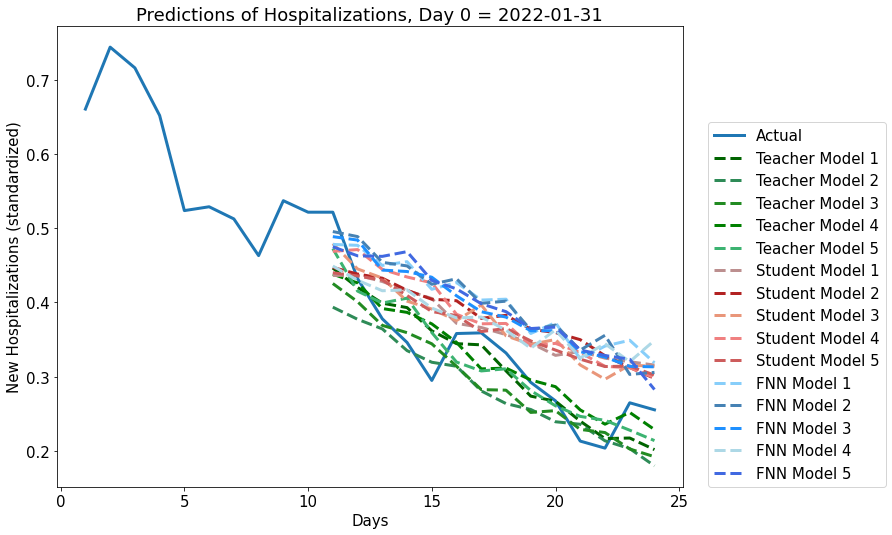

In [52]:
select_i_rand = [133, 306, 411, 505, 761]

colors1 = ['rosybrown', 'firebrick', 'darksalmon', 'lightcoral', 'indianred']
colors2 = ['lightskyblue', 'steelblue', 'dodgerblue', 'lightblue', 'royalblue']
colors3 = ['darkgreen', 'seagreen', 'forestgreen', 'green', 'mediumseagreen']

# Showing how the different models predict on a random test point

# Getting random test point
for i_rand in select_i_rand:
    print(i_rand)
    x_i = x[i_rand]
    y_i = y[i_rand]

    # Getting previous values of hospitalization
    prev_vals = []
    for i in x_i:
        prev_vals.append(i[4])
    y_i = torch.cat((torch.as_tensor(prev_vals), y_i))

    x_i = x_i.to(device).reshape(1, x_i.shape[0], x_i.shape[1]).type(torch.float)
    y_i = y_i.to(device)

    plt.clf()
    plt.figure(figsize=(10, 7.5))
    plt.xlabel('Days')
    plt.ylabel('New Hospitalizations (standardized)')

    plt.tight_layout()
    plt.rcParams.update({'font.size': 15})

    plt.plot(np.arange(1, len(y_i)+1), y_i, label='Actual', lw=3)

    # Plotting Teacher Model
    with torch.no_grad():
        for k in range(len(k_teacher_models)):
            model = k_teacher_models[k]
            model.eval()

            y_hat, _ = model(x_i, None)
            y_hat.reshape(14)

            plt.plot(np.arange(train_len+1, len(y_i)+1), np.array(y_hat)[0], '--',
                     color=colors3[k], label='Teacher Model ' + str(k+1), lw=3)

    # Plotting Student Model
    with torch.no_grad():
        for k in range(len(k_student_models)):
            model = k_student_models[k]
            model.eval()

            y_hat = model(x_i)
            y_hat.reshape(14)

            plt.plot(np.arange(train_len+1, len(y_i)+1), np.array(y_hat)[0], '--',
                     color=colors1[k], label='Student Model ' + str(k+1), lw=3)

    # Plotting Student FNN Model
    with torch.no_grad():
        for k in range(len(k_fnn_models)):
            model = k_fnn_models[k]
            model.eval()

            y_hat = model(x_i)
            y_hat.reshape(14)

            plt.plot(np.arange(train_len+1, len(y_i)+1), np.array(y_hat)[0], '--',
                     color=colors2[k], label='FNN Model ' + str(k+1), lw=3)



    plt.title(f'Predictions of Hospitalizations, Day 0 = {index[i_rand]}')
    plt.legend(loc=(1.04,0))
    
    plt.savefig(f'charts/prediction_obs_{i_rand}.png', bbox_inches='tight')
    
    plt.show()